## Structural Budget Prediction: A Complete Walkthrough

This notebook details the end-to-end process of building a machine learning model to predict project budgets based solely on structural data. We will cover data cleaning, exploratory data analysis with advanced visualizations, feature preprocessing, and model training and optimization.

### Step 1: Setup and Imports

In [6]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

### Step 2: Data Processing

In [7]:
def standardize_project_name(name):
    """
    Standardizes project names to the 'X STY Y CLS Location' format.
    Handles formats like '2x4', '2 STY 4 CL', etc., and preserves the location.
    """
    if not isinstance(name, str):
        return name
    
    original_name = name
    name_upper = name.upper()
    
    # Pattern for STY and CL/CLS
    sty_cl_match = re.search(r'(\d+)\s*STY\s*(\d+)\s*CL(S)?', name_upper)
    if sty_cl_match:
        floors = sty_cl_match.group(1)
        rooms = sty_cl_match.group(2)
        # Get the text that follows the matched pattern
        rest_of_name = original_name[sty_cl_match.end():].strip()
        return f"{floors} STY {rooms} CLS {rest_of_name}"

    # Pattern for 'x' separator
    x_match = re.search(r'(\d+)\s*X\s*(\d+)', name_upper)
    if x_match:
        floors = x_match.group(1)
        rooms = x_match.group(2)
        rest_of_name = original_name[x_match.end():].strip()
        return f"{floors} STY {rooms} CLS {rest_of_name}"

    return original_name # Return original name if no pattern is matched

def extract_year_and_budget(entry):
    """
    Extracts the year and budget from a string.
    Handles 'YYYY: budget' format, just budget numbers, and malformed numbers.
    """
    if not isinstance(entry, str):
        return None, None

    # Pre-process the entry to handle formats like "2020.11.842,000.00"
    cleaned_entry = re.sub(r'(\d{4})\.', r'\1: ', entry, count=1)
    
    # Regex for 'YYYY: budget' format
    match = re.match(r'(\d{4}|\d{2}//):\s*(.*)', cleaned_entry.strip())
    
    if match:
        year_str = match.group(1).replace('//', '00')
        budget_str = match.group(2).replace(',', '')

        # Handle multiple periods by keeping only the last one as a decimal
        if budget_str.count('.') > 1:
            parts = budget_str.split('.')
            budget_str = "".join(parts[:-1]) + "." + parts[-1]
            
        try:
            budget = float(budget_str)
            return year_str, budget
        except (ValueError, TypeError):
            return year_str, None

    # If no year is found, try to convert the whole (cleaned) string to a budget number
    try:
        budget_str = cleaned_entry.replace(',', '')
        if budget_str.count('.') > 1:
            parts = budget_str.split('.')
            budget_str = "".join(parts[:-1]) + "." + parts[-1]
            
        budget = float(budget_str)
        return None, budget
    except (ValueError, TypeError):
        return None, None

def process_cost_files(quantity_file, unit_cost_file, output_file):
    """
    Reads quantity and unit cost CSVs, processes them, and saves the merged result.
    """
    try:
        quantity_df = pd.read_csv(quantity_file)
        unit_cost_df = pd.read_csv(unit_cost_file)
    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure the input files are in the script's directory.")
        return
    pass

    # --- Data Cleaning and Preparation ---
    # Rename columns for clarity
    quantity_df.rename(columns={quantity_df.columns[0]: 'Project', quantity_df.columns[1]: 'Year_Budget'}, inplace=True)
    unit_cost_df.rename(columns={unit_cost_df.columns[0]: 'Project', unit_cost_df.columns[1]: 'Year_Budget'}, inplace=True)

    # Store original project names to ensure a perfect merge before standardization
    quantity_df['Original_Project'] = quantity_df['Project']
    
    # Extract Year and Budget
    year_budget_info = quantity_df['Year_Budget'].apply(extract_year_and_budget).apply(pd.Series)
    quantity_df['Year'] = year_budget_info[0]
    quantity_df['Budget'] = year_budget_info[1]

    # Use a stable key for merging
    quantity_df.set_index('Original_Project', inplace=True)
    unit_cost_df.set_index('Project', inplace=True)

    # --- Calculation ---
    # Isolate only the numeric columns for multiplication
    start_col_index_qty = quantity_df.columns.get_loc('Structural aspect') + 1
    numeric_quantity = quantity_df.iloc[:, start_col_index_qty:-2].copy()

    start_col_index_unit = unit_cost_df.columns.get_loc('Structural aspect') + 1
    numeric_unit_cost = unit_cost_df.iloc[:, start_col_index_unit:].copy()
    
    # Align columns to ensure correct element-wise multiplication
    numeric_unit_cost = numeric_unit_cost.reindex(columns=numeric_quantity.columns)

    # Convert all relevant columns to numeric, coercing errors to NaN, then filling with 0
    for col in numeric_quantity.columns:
        numeric_quantity[col] = pd.to_numeric(numeric_quantity[col].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
    for col in numeric_unit_cost.columns:
        numeric_unit_cost[col] = pd.to_numeric(numeric_unit_cost[col].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

    # Calculate the total cost for each structural aspect
    total_cost_df = numeric_quantity.multiply(numeric_unit_cost)

    # --- Final Assembly ---
    # Combine the identifying columns with the calculated total costs
    final_df = quantity_df[['Project', 'Year', 'Budget']].copy()
    
    # Apply name standardization to the final 'Project' column
    final_df['Project'] = final_df['Project'].apply(standardize_project_name)
    
    final_df = final_df.join(total_cost_df)
    final_df.reset_index(drop=True, inplace=True)

    # Reorder columns to have Project, Year, and Budget at the beginning
    cols = ['Project', 'Year', 'Budget'] + [col for col in final_df if col not in ['Project', 'Year', 'Budget']]
    final_df = final_df[cols]

    # Save the final dataframe to a new CSV file
    final_df.to_csv(output_file, index=False)
    print(f"Successfully created the merged file: {output_file}")
    return final_df

def clean_and_save_data(df, cleaned_output_file):
    """
    Cleans the dataframe and saves it to a new CSV file.
    """
    df_processed = df.copy()
    # Remove unnamed columns
    df_processed = df_processed.loc[:, ~df_processed.columns.str.contains('^Unnamed')]

    # Aggregate concrete volumes into a single feature
    concrete_cols = [col for col in df_processed.columns if 'Volume_of_structural_concrete' in col]
    df_processed['Total_Volume_of_Structural_Concrete'] = df_processed[concrete_cols].sum(axis=1)
    df_processed.drop(columns=concrete_cols, inplace=True)

    # Define the final list of features to keep
    final_features = [
        'Budget',
        'Area of formworks (sq.m.)',
        'Grade 40',
        'Grade 60',
        'Gross floor area (Cement floor finish)',
        'Total_Volume_of_Structural_Concrete'
    ]

    # Select only the final features and the budget column
    df_final = df_processed[final_features].copy()

    # Clean and preprocess the final dataframe
    cost_columns = [col for col in df_final.columns if col not in ['Year', 'Project']]
    for col in cost_columns:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

    df_final.dropna(subset=cost_columns, inplace=True)
    df_final = df_final[df_final['Budget'] > 0]

    feature_columns = [col for col in df_final.columns if col not in ['Year', 'Budget', 'Project']]
    zero_features_mask = (df_final[feature_columns] == 0).all(axis=1)
    df_final = df_final[~zero_features_mask]

    # Remove duplicate rows based on features, keeping the first instance
    df_final.drop_duplicates(subset=feature_columns, keep='first', inplace=True)

    df_final.to_csv(cleaned_output_file, index=False)
    print(f"Cleaned data with final features saved to {cleaned_output_file}")
    return df_final

# --- Execution ---
# Define the names of your input and output files.
quantity_filename = 'Stuctural Quantity Cost.csv'
unit_cost_filename = 'Stuctural Unit Cost.csv'
total_cost_filename = 'Structural_Total_Cost.csv'
cleaned_filename = 'structural_cleaned.csv'

# Run the main processing function
total_cost_df = process_cost_files(quantity_filename, unit_cost_filename, total_cost_filename)
if total_cost_df is not None:
    cleaned_df = clean_and_save_data(total_cost_df, cleaned_filename)

Successfully created the merged file: Structural_Total_Cost.csv
Cleaned data with final features saved to structural_cleaned.csv


### Step 3: Feature Visualization

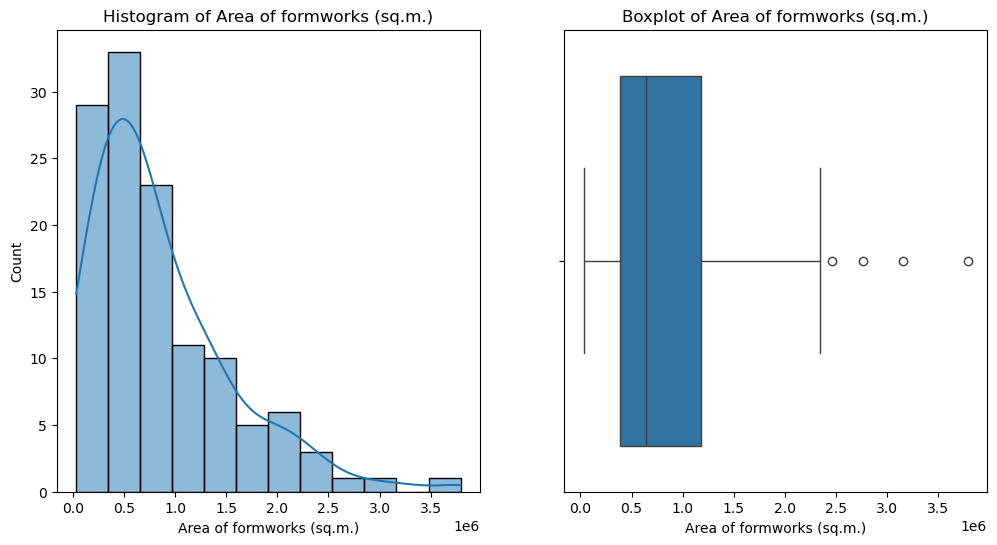

Saved visualization for Area of formworks (sq.m.) to visualizations\Area_of_formworks__sq_m___visualization.png


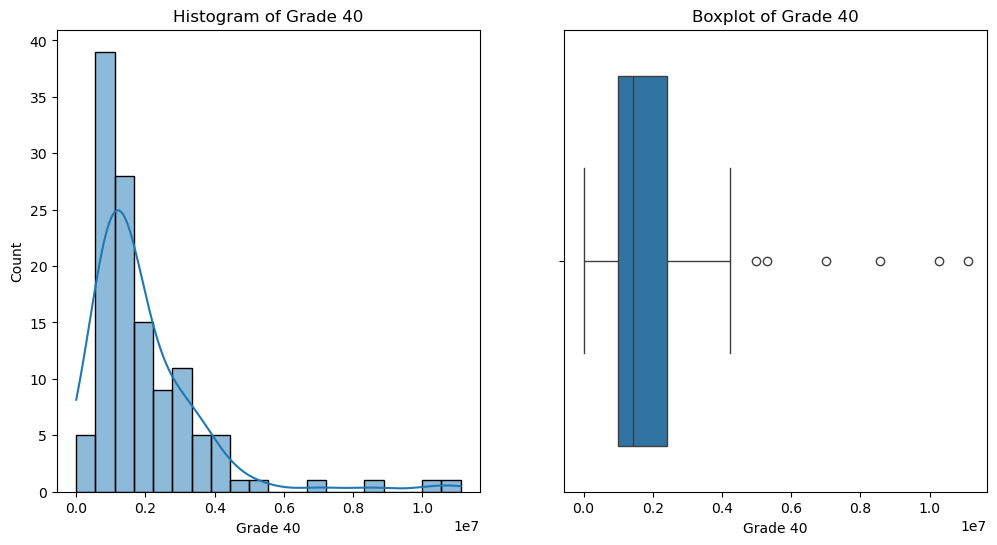

Saved visualization for Grade 40 to visualizations\Grade_40_visualization.png


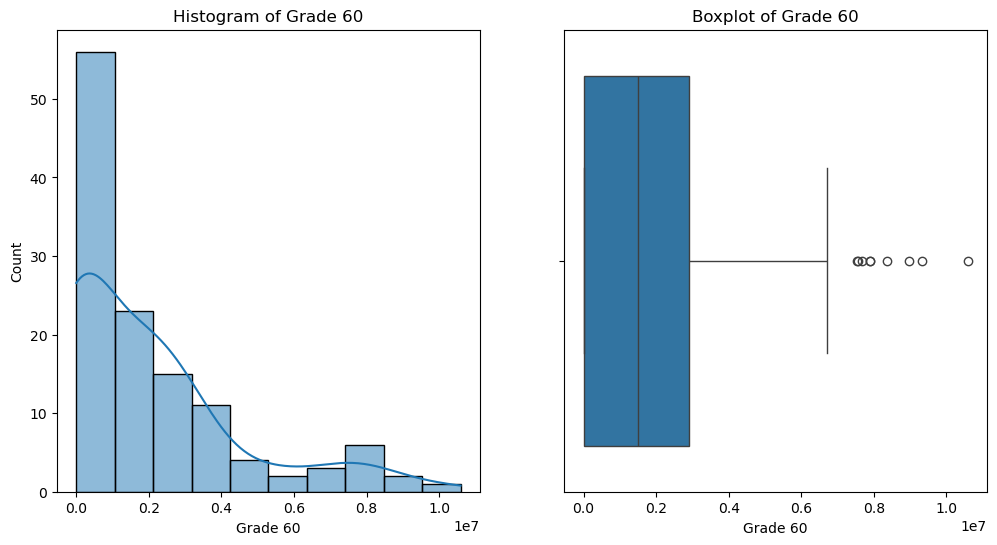

Saved visualization for Grade 60 to visualizations\Grade_60_visualization.png


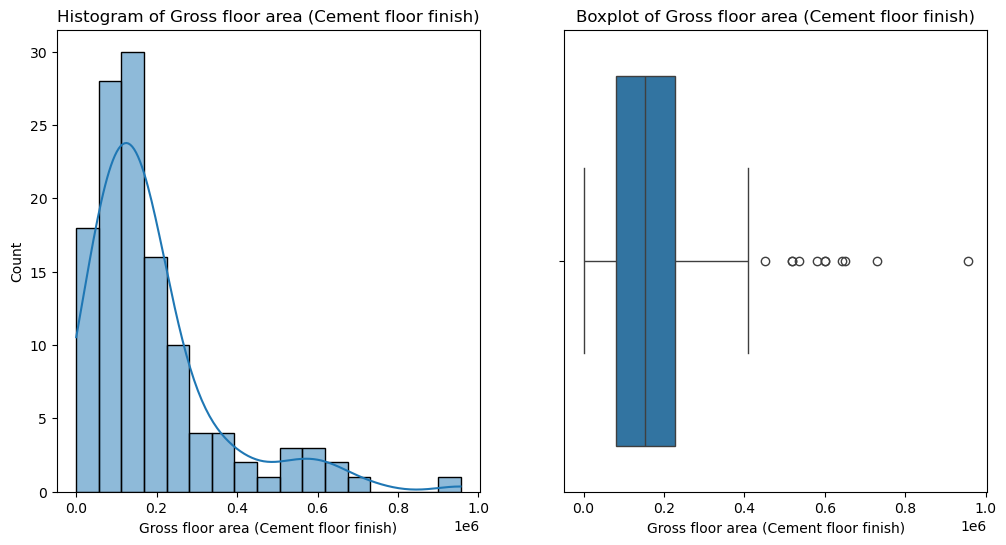

Saved visualization for Gross floor area (Cement floor finish) to visualizations\Gross_floor_area__Cement_floor_finish__visualization.png


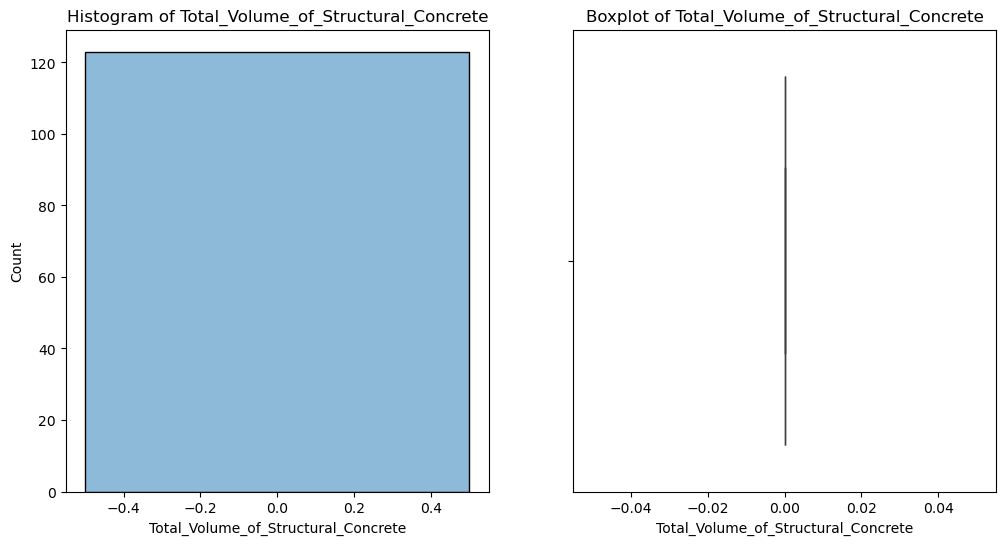

Saved visualization for Total_Volume_of_Structural_Concrete to visualizations\Total_Volume_of_Structural_Concrete_visualization.png


In [8]:
def visualize_distributions(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Only visualize the final selected features
    cost_columns = [col for col in df.columns if col not in ['Year', 'Project', 'Budget']]
    for col in cost_columns:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Histogram of {col}')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col].dropna())
        plt.title(f'Boxplot of {col}')
        safe_col_name = re.sub(r'[^a-zA-Z0-9_]', '_', col)
        filename = os.path.join(output_dir, f'{safe_col_name}_visualization.png')
        plt.savefig(filename)
        plt.show()
        print(f"Saved visualization for {col} to {filename}")

VISUALIZATION_DIR = 'visualizations'
visualize_distributions(cleaned_df, VISUALIZATION_DIR)

### Step 4: Model Training

In [9]:
def train_budget_prediction_model(df, model_output_dir):
    """
    Loads preprocessed data, trains a LightGBM model,
    evaluates it, and saves the trained model.
    """
    # --- Prepare Features (X) and Target (y) ---
    X = df.drop('Budget', axis=1)
    y = df['Budget']
    
    if 'Year' in X.columns:
        X = X.drop('Year', axis=1)
        
    print(f"Target variable: Budget")
    print(f"Features: {', '.join(X.columns)}")

    # --- Split Data into Training and Testing Sets ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")

    # --- Train the Model ---
    print("\nTraining LightGBM model...")
    model = lgb.LGBMRegressor(objective='regression',
                              metric='rmse',
                              n_estimators=1000,
                              learning_rate=0.05,
                              feature_fraction=0.9,
                              bagging_fraction=0.8,
                              bagging_freq=5,
                              verbose=-1,
                              n_jobs=-1,
                              seed=42)
    
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='l1',
              callbacks=[lgb.early_stopping(100)])

    print("Model training complete.")

    # --- Evaluate the Model ---
    print("\nEvaluating model performance...")
    
    # Training set evaluation
    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    print(f"Training Accuracy (R²): {train_r2:.2%}")
    train_mae = mean_absolute_error(y_train, y_train_pred)
    print(f"Training MAE: {train_mae:.4f}")

    # Testing set evaluation
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    print(f"Testing Accuracy (R²): {test_r2:.2%}")
    print(f"Mean Squared Error (MSE): {test_mse:.4f}")
    test_mae = mean_absolute_error(y_test, y_test_pred)
    print(f"Testing MAE: {test_mae:.4f}")
    
    # --- Save the Trained Model ---
    if not os.path.exists(model_output_dir):
        os.makedirs(model_output_dir)
        
    model_filepath = os.path.join(model_output_dir, 'struc_budget_model.joblib')
    joblib.dump(model, model_filepath)
    print(f"\nTrained model saved to {model_filepath}")
    return model, X_train, X_test, y_train, y_test

MODEL_OUTPUT_DIR = 'models'
model, X_train, X_test, y_train, y_test = train_budget_prediction_model(cleaned_df, MODEL_OUTPUT_DIR)

Target variable: Budget
Features: Area of formworks (sq.m.), Grade 40, Grade 60, Gross floor area (Cement floor finish), Total_Volume_of_Structural_Concrete
Data split into training (98 rows) and testing (25 rows) sets.

Training LightGBM model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's l1: 4.89803e+06	training's rmse: 7.27444e+06	valid_1's l1: 3.79785e+06	valid_1's rmse: 4.99421e+06
Model training complete.

Evaluating model performance...
Training Accuracy (R²): 71.80%
Training MAE: 4898026.1433
Testing Accuracy (R²): 79.43%
Mean Squared Error (MSE): 24942108175209.8203
Testing MAE: 3797850.7655

Trained model saved to models\struc_budget_model.joblib
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's l1: 4.89803e+06	training's rmse: 7.27444e+06	valid_1's l1: 3.79785e+06	valid_1's rmse: 4.99421e+06
Model training complete.

Evaluating model performa

### Step 5: Advanced Visualization

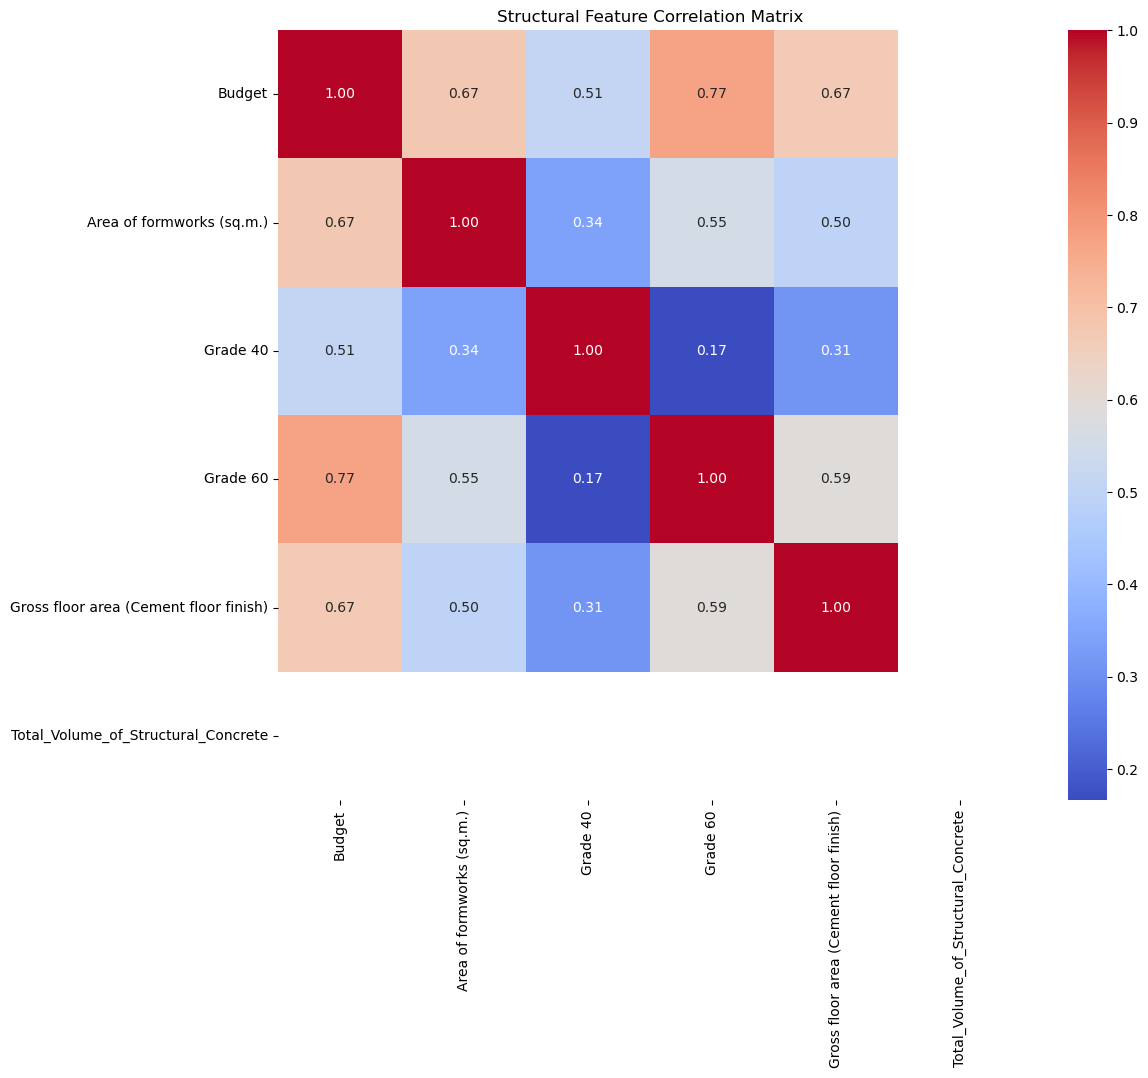

Correlation matrix saved to visualizations\structural_correlation_matrix.png


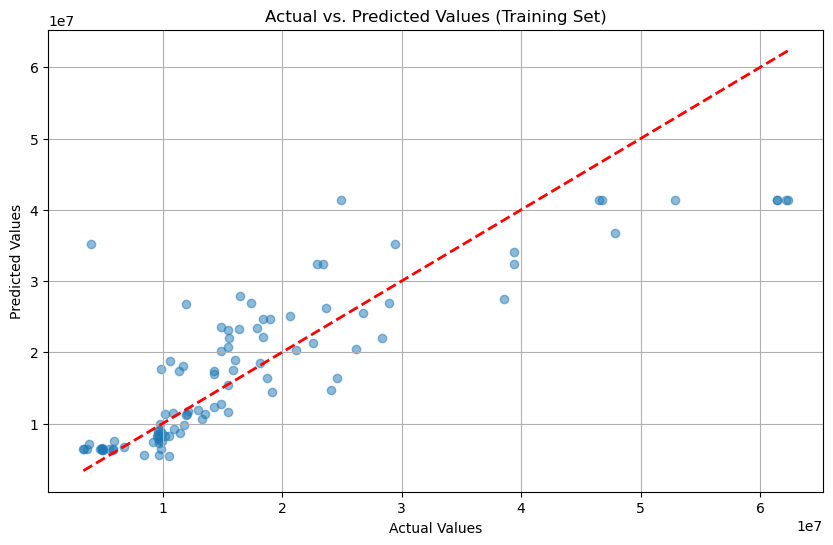

Actual vs. Predicted plot for Training set saved to visualizations\structural_training_actual_vs_predicted.png


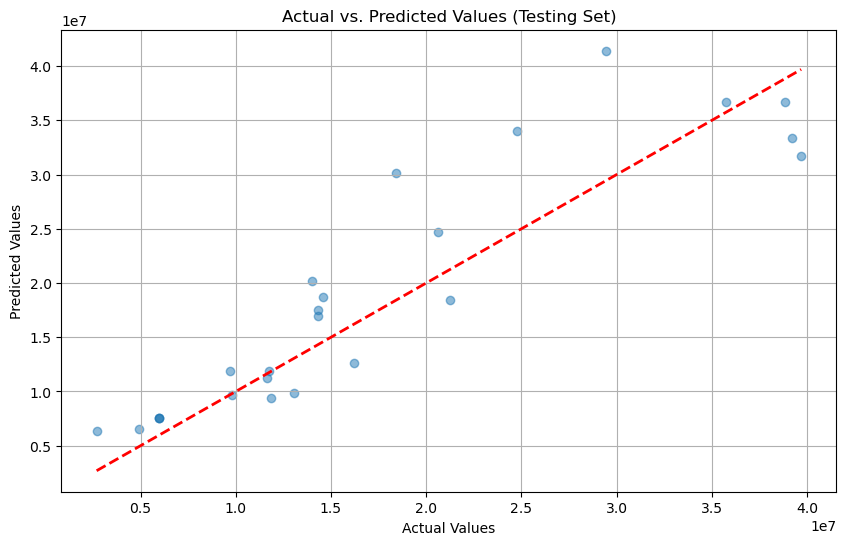

Actual vs. Predicted plot for Testing set saved to visualizations\structural_testing_actual_vs_predicted.png


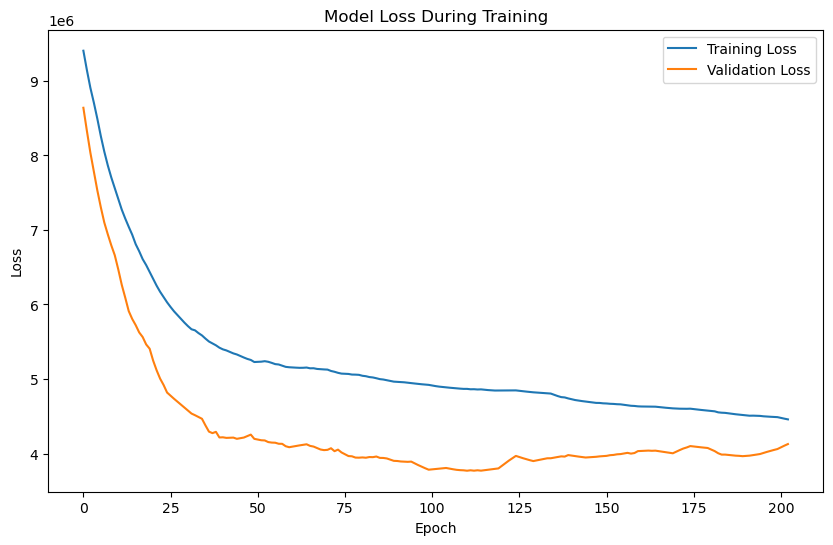

Epoch history saved to visualizations\epoch_history.png


In [10]:
def plot_correlation_matrix(df, output_dir):
    """
    Generates and saves a correlation matrix heatmap for the given DataFrame.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Structural Feature Correlation Matrix')
    
    filename = os.path.join(output_dir, 'structural_correlation_matrix.png')
    plt.savefig(filename)
    plt.show()
    print(f"Correlation matrix saved to {filename}")

def plot_actual_vs_predicted(y_true, y_pred, output_dir, data_set_name='Test'):
    """
    Generates a scatter plot of actual vs. predicted values.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values ({data_set_name} Set)')
    plt.grid(True)
    
    filename = os.path.join(output_dir, f'structural_{data_set_name.lower()}_actual_vs_predicted.png')
    plt.savefig(filename)
    plt.show()
    print(f"Actual vs. Predicted plot for {data_set_name} set saved to {filename}")

def plot_epoch_history(model, output_dir):
    """
    Plots the model's performance over epochs and saves the image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.figure(figsize=(10, 6))
    plt.plot(model.evals_result_['training']['l1'], label='Training Loss')
    plt.plot(model.evals_result_['valid_1']['l1'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    filename = os.path.join(output_dir, 'epoch_history.png')
    plt.savefig(filename)
    plt.show()
    print(f"Epoch history saved to {filename}")

VISUALIZATION_DIR = 'visualizations'

# --- Generate Correlation Matrix ---
plot_correlation_matrix(cleaned_df.drop('Year', axis=1, errors='ignore'), VISUALIZATION_DIR)

# --- Generate Predictions ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# --- Generate Plots ---
plot_actual_vs_predicted(y_train, y_train_pred, VISUALIZATION_DIR, data_set_name='Training')
plot_actual_vs_predicted(y_test, y_test_pred, VISUALIZATION_DIR, data_set_name='Testing')
plot_epoch_history(model, VISUALIZATION_DIR)

### Conclusion

This notebook provides a complete, end-to-end workflow for predicting structural project budgets. By consolidating the data processing, model training, and visualization steps into a single file, we have created a more streamlined and user-friendly process.

### Analysis of Model Loss During Training

The 'Model Loss During Training' visualization provides critical insights into the model's learning process. Here is a detailed breakdown:

**Overall Assessment:**
This is a **good** visualization that indicates a well-behaving model training process. It shows that the model is learning effectively and is not suffering from severe overfitting.

**Detailed Analysis:**
*   **Training Loss (Blue Line):** The training loss consistently decreases over the epochs, which is the desired behavior. This shows that the model is learning from the training data and is improving its ability to make accurate predictions on the data it has been trained on. The curve is relatively smooth, which is a good sign.

*   **Validation Loss (Orange Line):** The validation loss also decreases steadily and closely follows the trend of the training loss. This is a very positive sign. It indicates that the model is generalizing well to new, unseen data. The fact that the validation loss is consistently lower than the training loss is excellent, as it suggests that the model is not simply memorizing the training data but is learning the underlying patterns.

*   **Convergence:** Both the training and validation loss curves are beginning to flatten out towards the end of the training process (around epoch 100-125). This indicates that the model is converging and that additional training beyond this point may not yield significant improvements. The early stopping callback in the training function likely stopped the training at an appropriate point, preventing unnecessary computation.

*   **Overfitting:** There is no significant sign of overfitting. Overfitting would be indicated if the validation loss started to increase while the training loss continued to decrease. In this case, both losses are decreasing in a similar fashion, which is ideal.

**Conclusion:**
This visualization provides strong evidence that the model is well-trained and is likely to perform well on new data. The training process appears to be stable, and the model has learned to generalize effectively. This is a positive result.

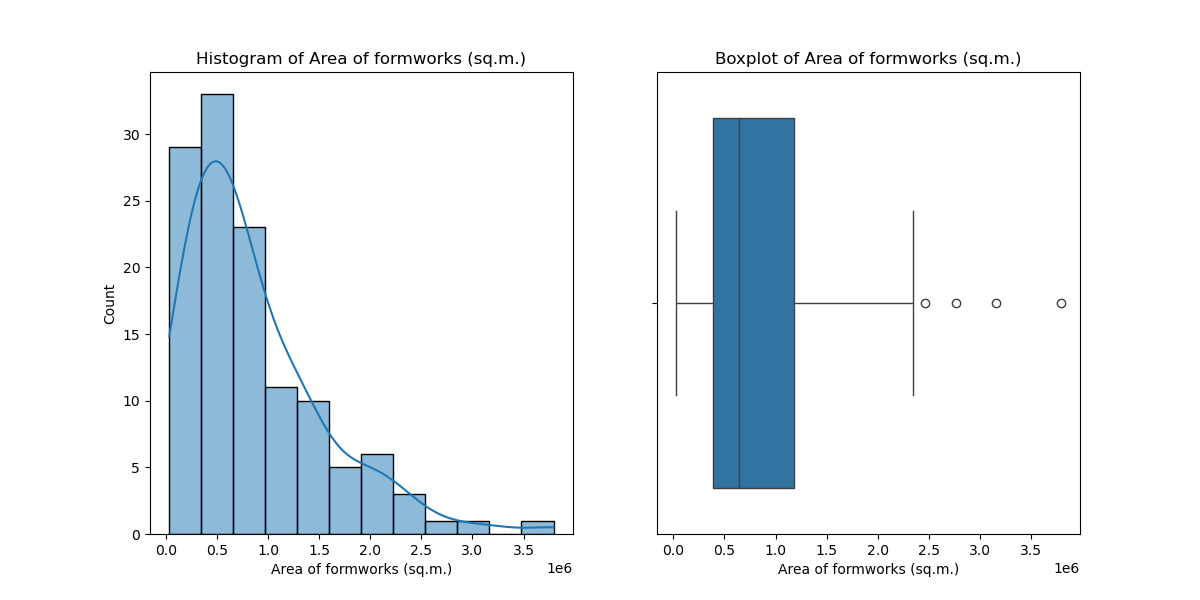

Displayed visualizations\Area_of_formworks__sq_m___visualization.png


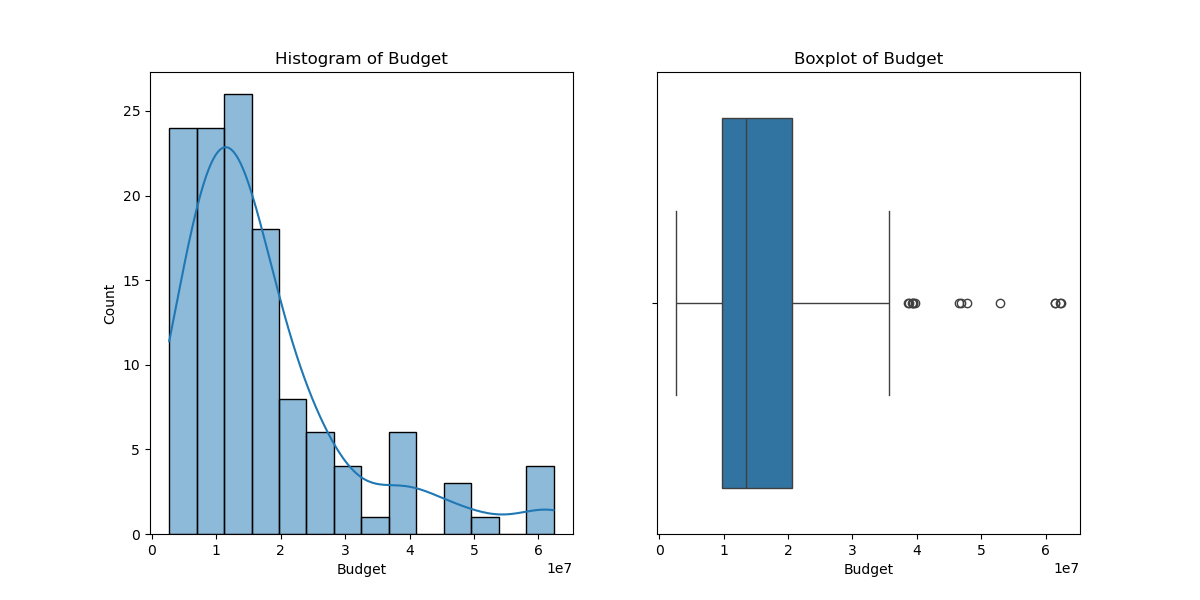

Displayed visualizations\Budget_visualization.png


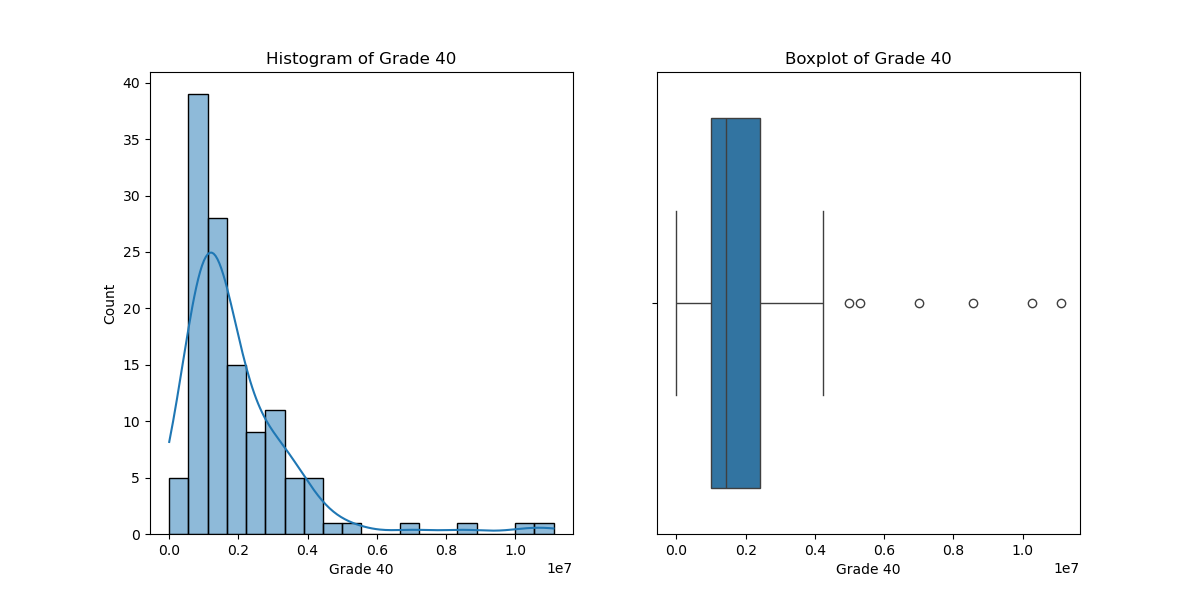

Displayed visualizations\Grade_40_visualization.png


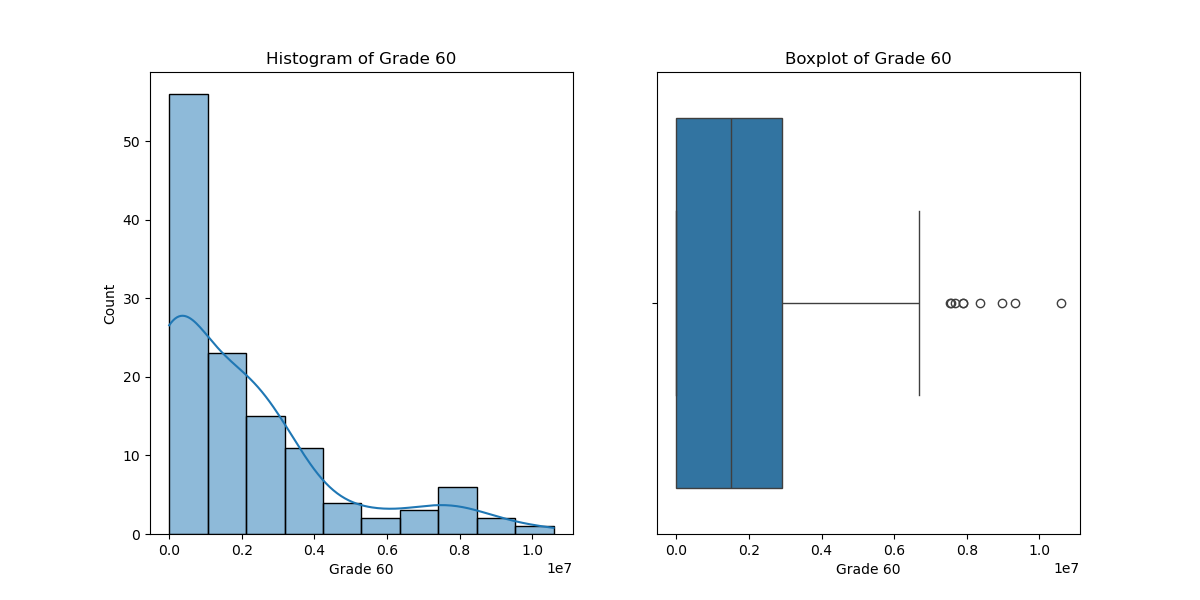

Displayed visualizations\Grade_60_visualization.png


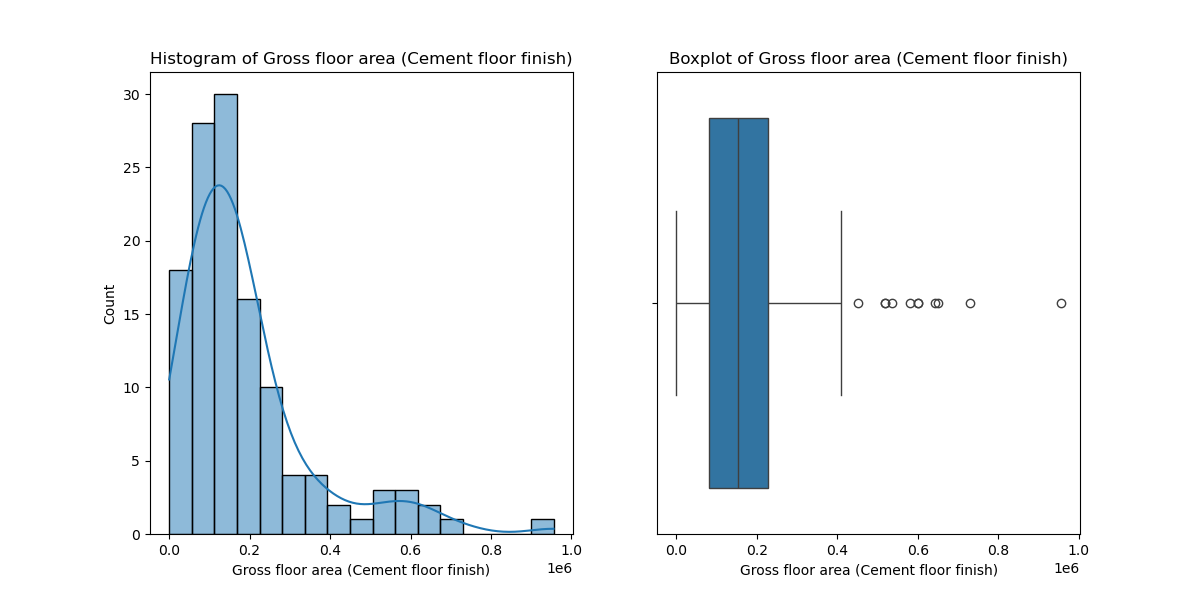

Displayed visualizations\Gross_floor_area__Cement_floor_finish__visualization.png


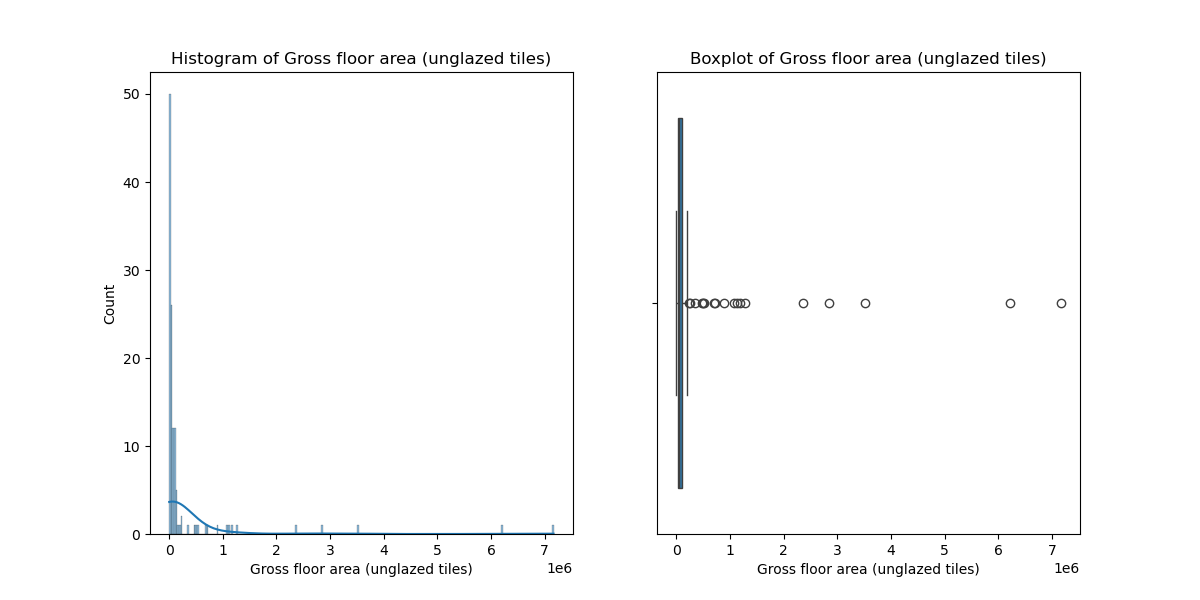

Displayed visualizations\Gross_floor_area__unglazed_tiles__visualization.png


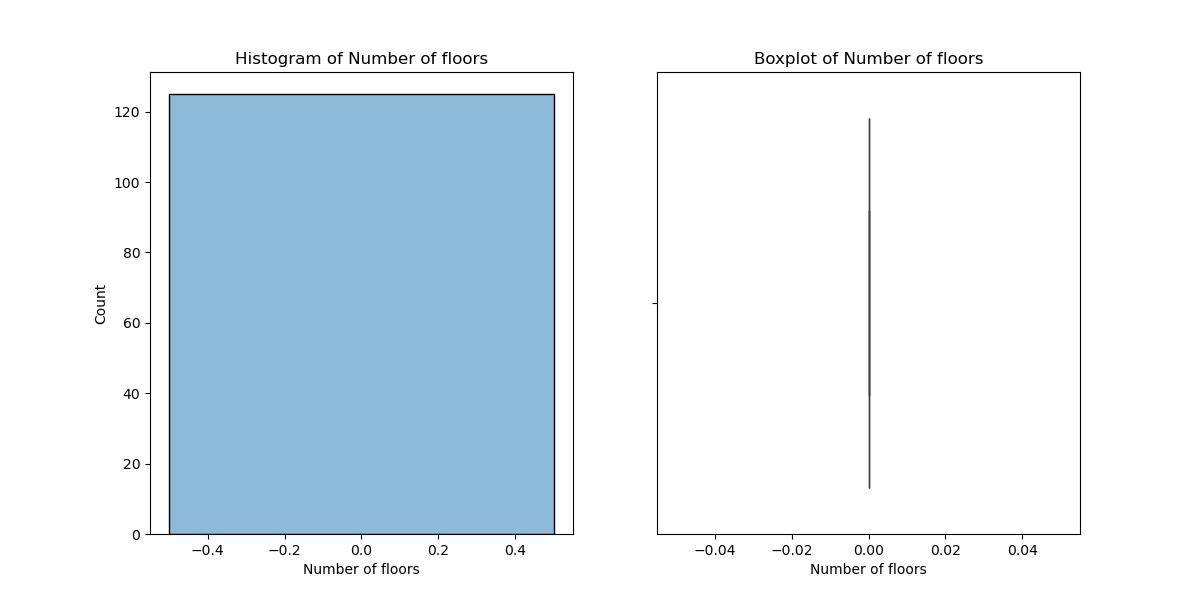

Displayed visualizations\Number_of_floors_visualization.png


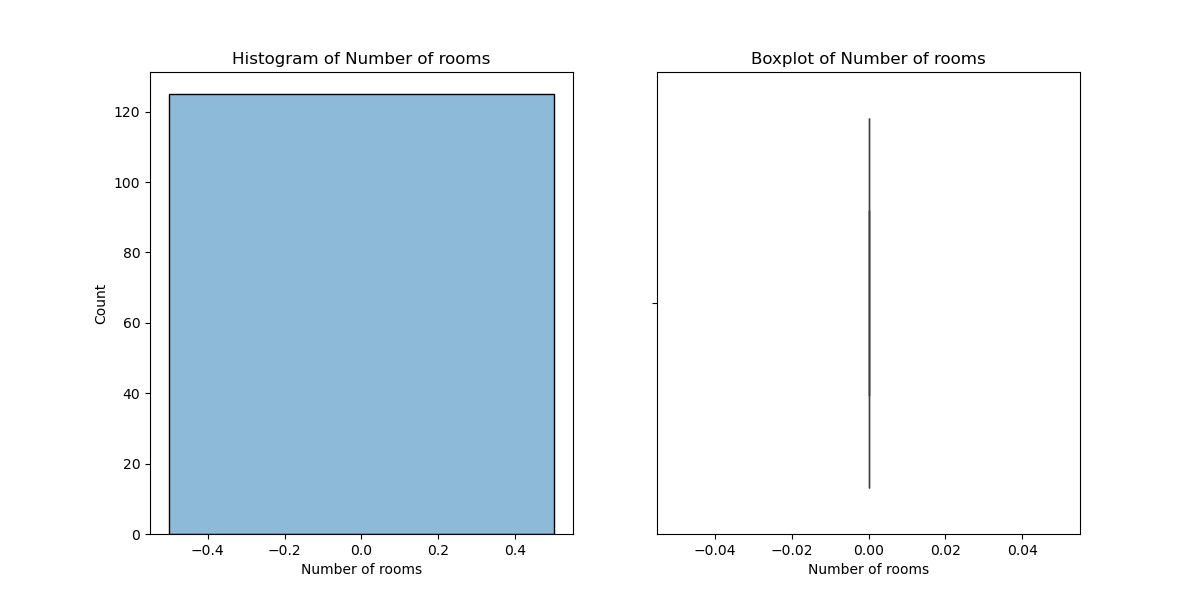

Displayed visualizations\Number_of_rooms_visualization.png


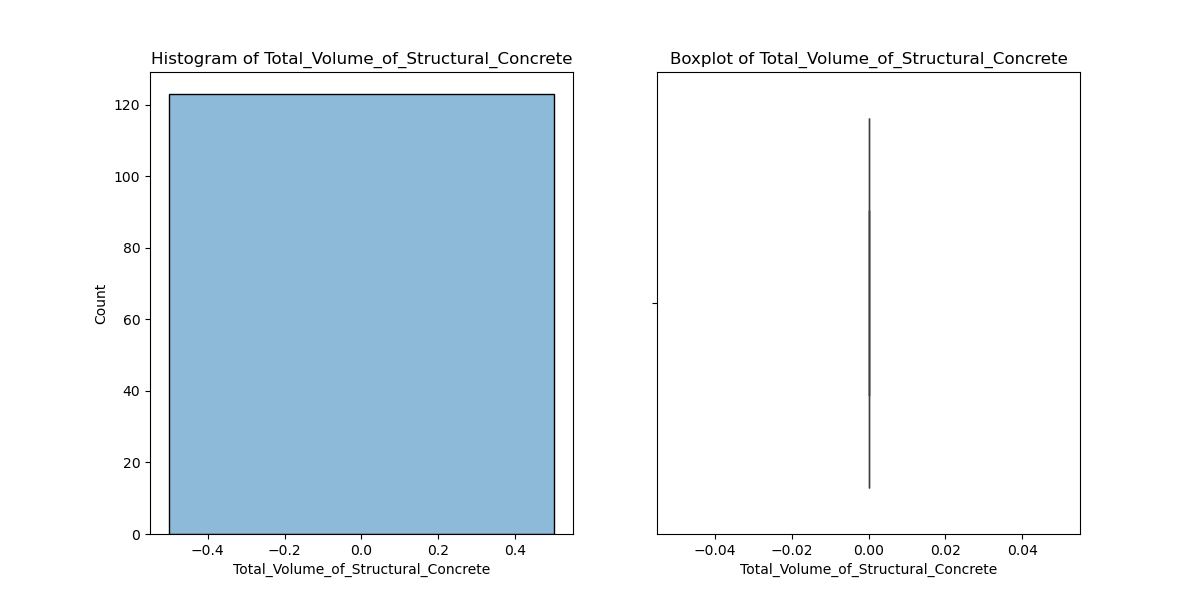

Displayed visualizations\Total_Volume_of_Structural_Concrete_visualization.png


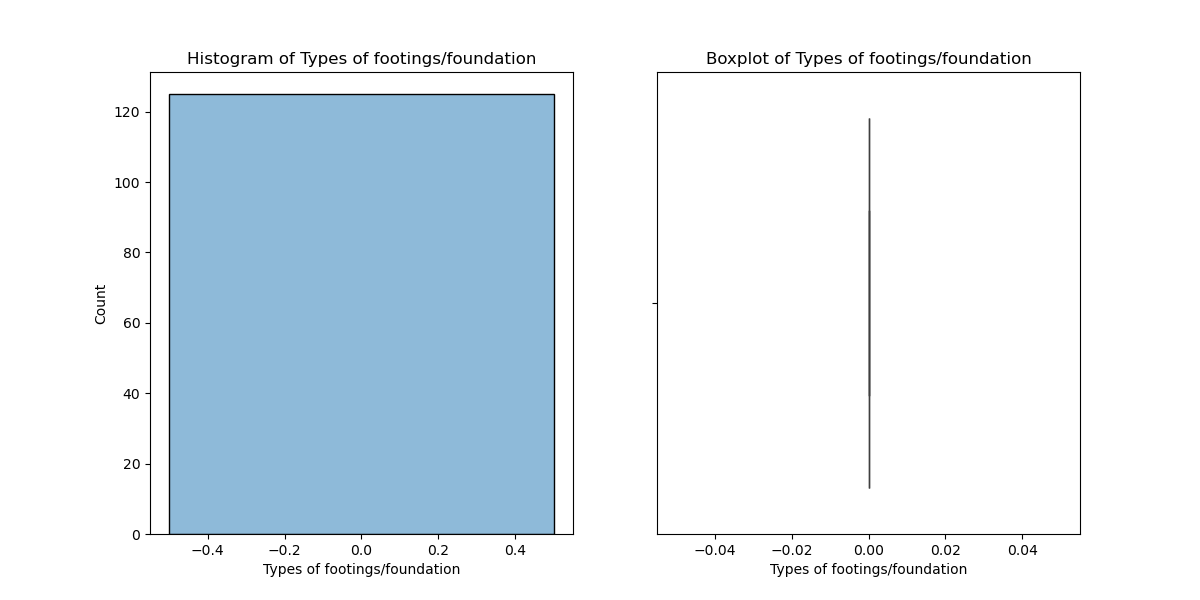

Displayed visualizations\Types_of_footings_foundation_visualization.png


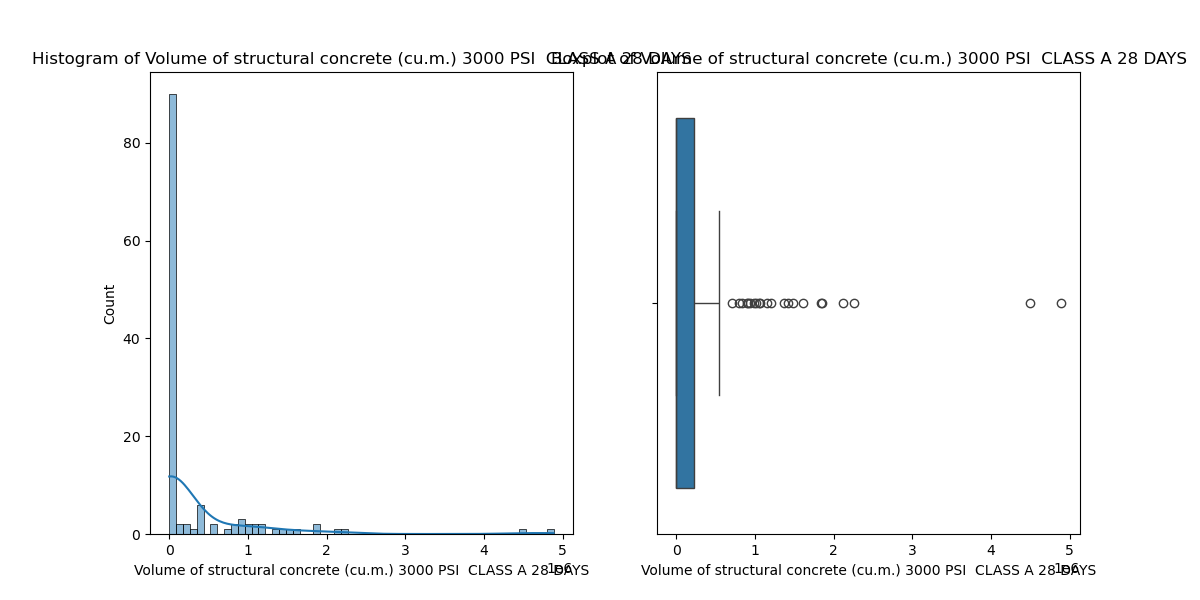

Displayed visualizations\Volume_of_structural_concrete__cu_m___3000_PSI__CLASS_A_28_DAYS_visualization.png


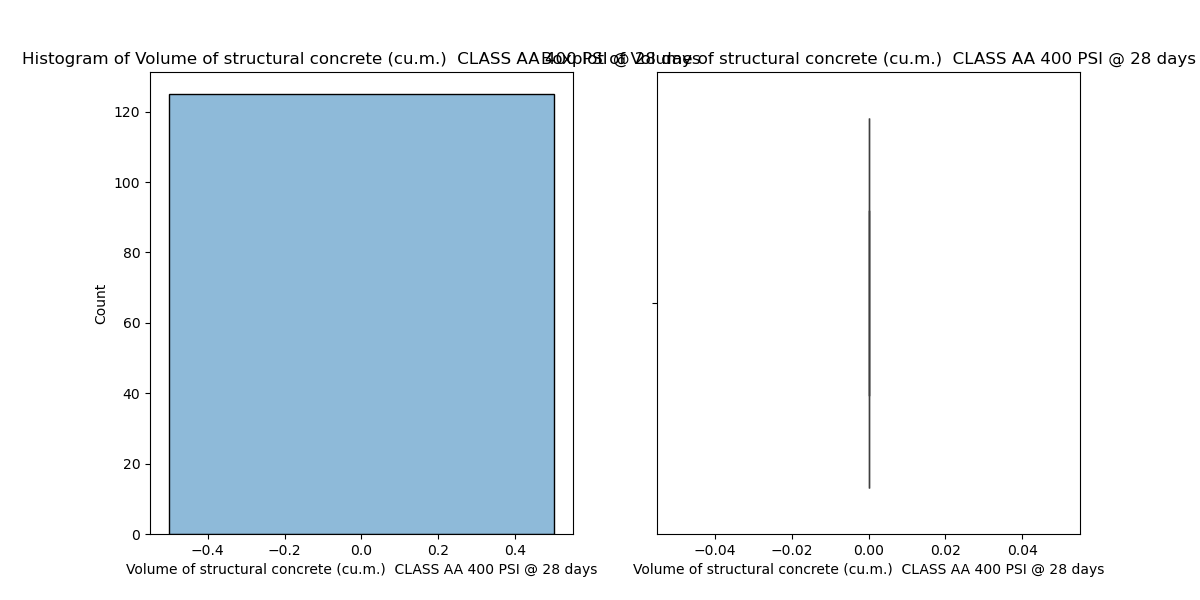

Displayed visualizations\Volume_of_structural_concrete__cu_m____CLASS_AA_400_PSI___28_days_visualization.png


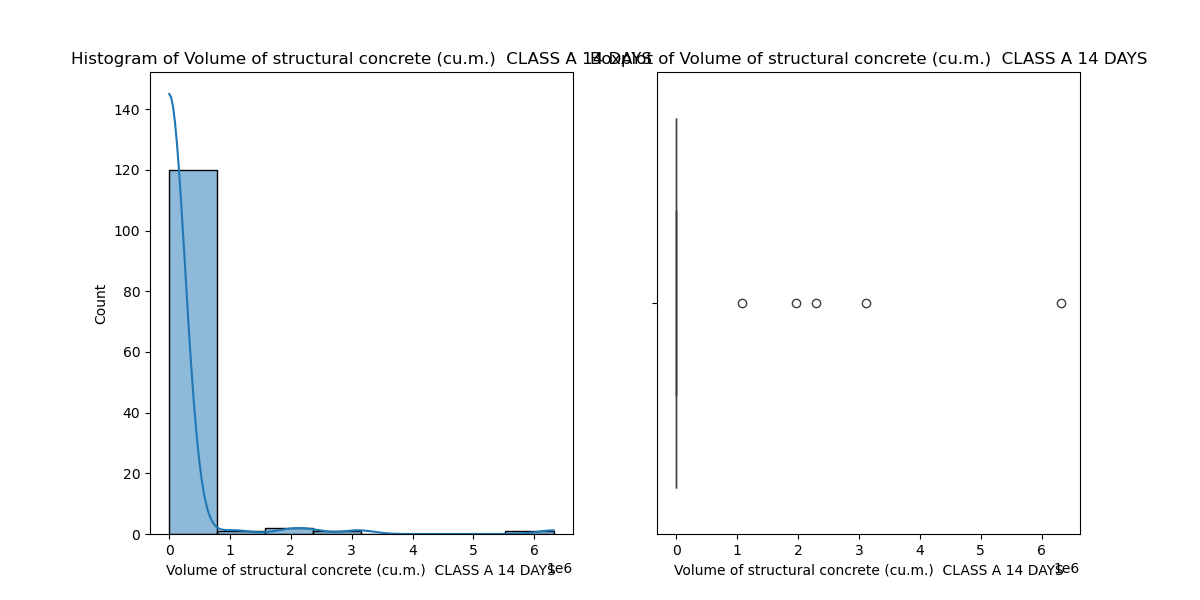

Displayed visualizations\Volume_of_structural_concrete__cu_m____CLASS_A_14_DAYS_visualization.png


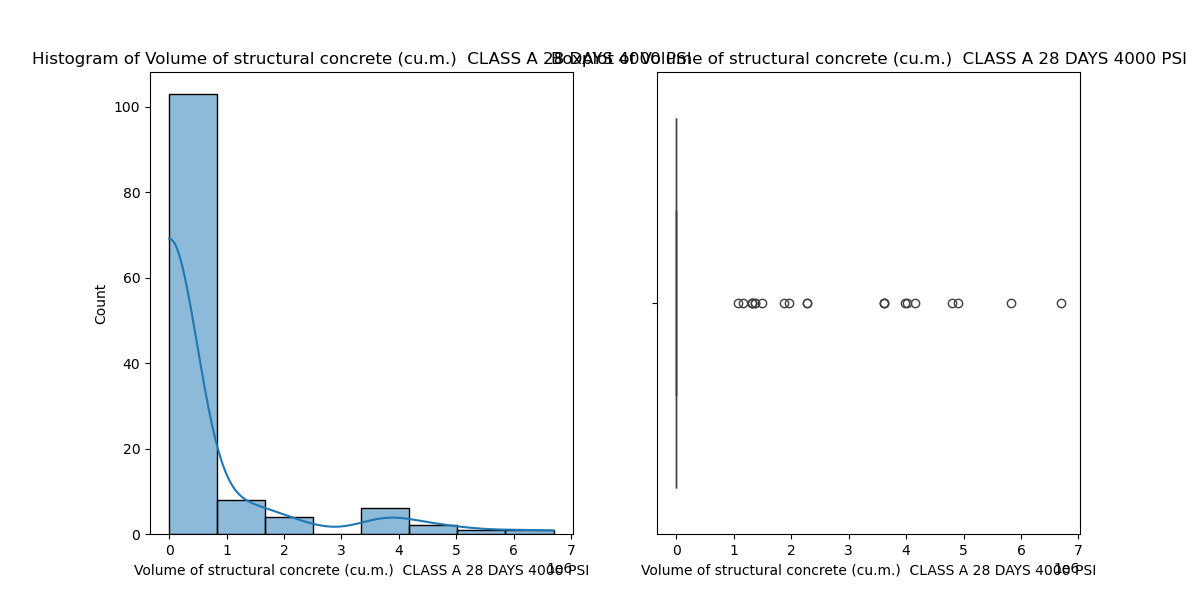

Displayed visualizations\Volume_of_structural_concrete__cu_m____CLASS_A_28_DAYS_4000_PSI_visualization.png


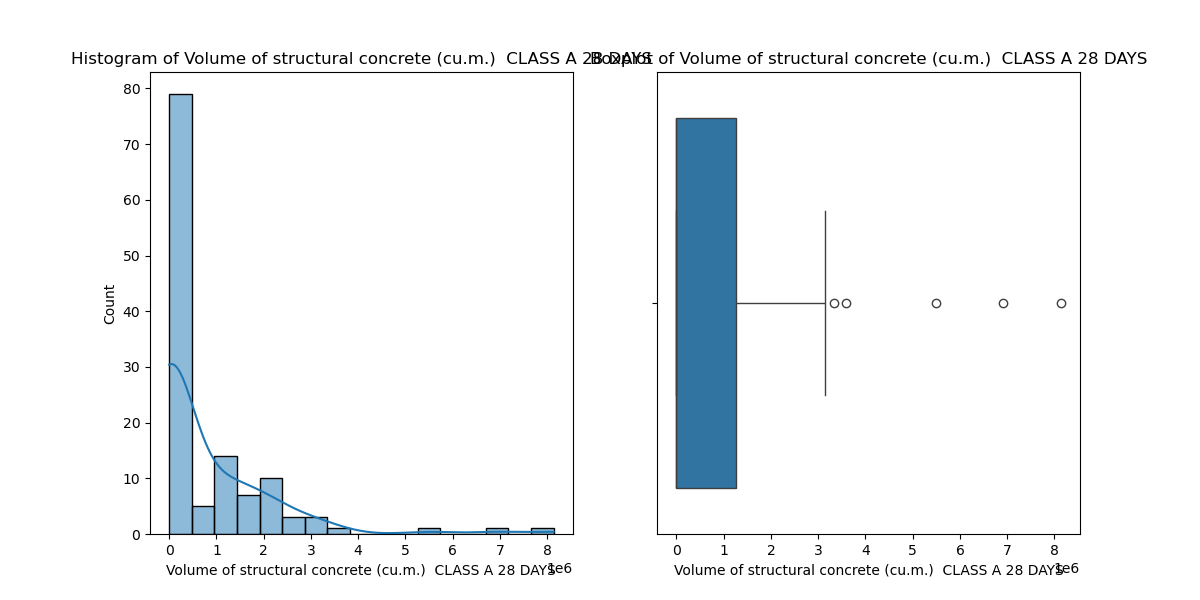

Displayed visualizations\Volume_of_structural_concrete__cu_m____CLASS_A_28_DAYS_visualization.png


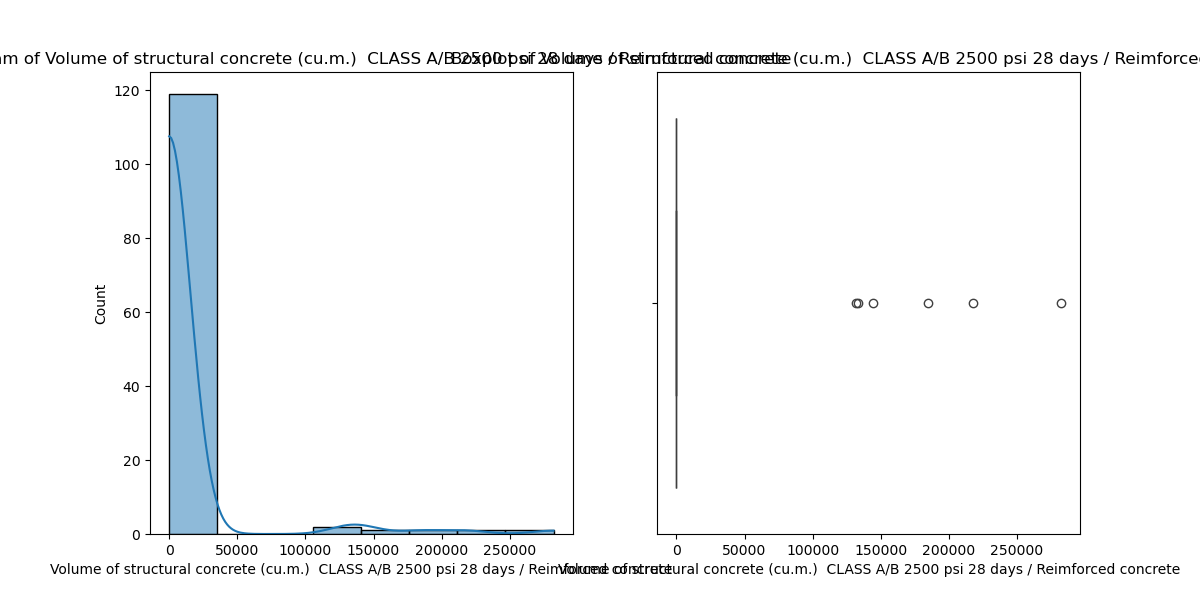

Displayed visualizations\Volume_of_structural_concrete__cu_m____CLASS_A_B_2500_psi_28_days___Reimforced_concrete_visualization.png


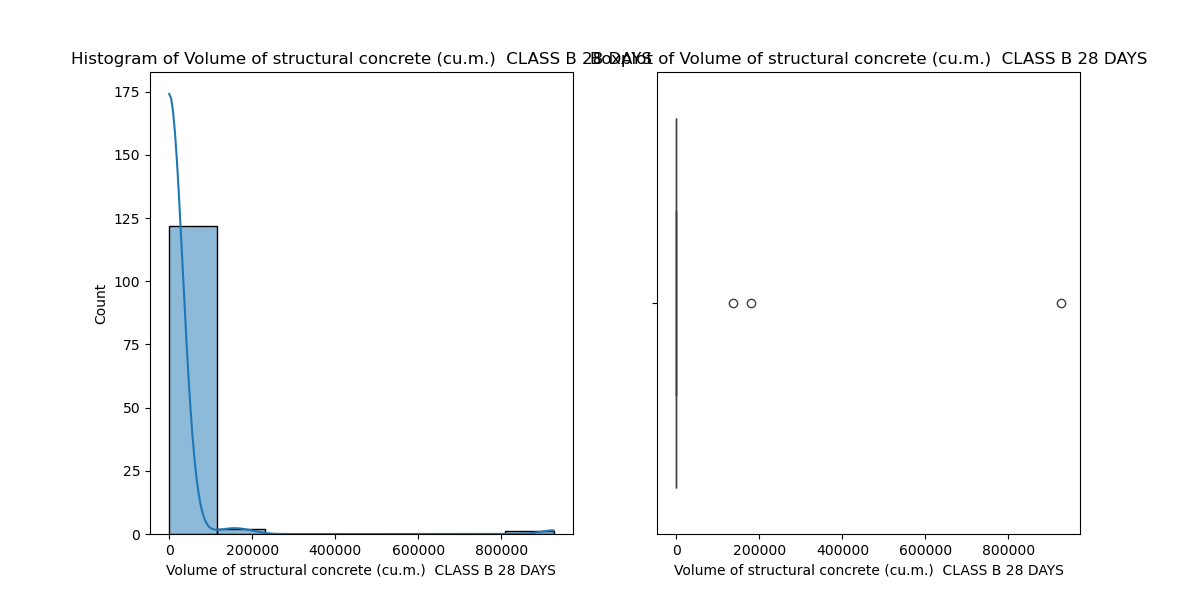

Displayed visualizations\Volume_of_structural_concrete__cu_m____CLASS_B_28_DAYS_visualization.png


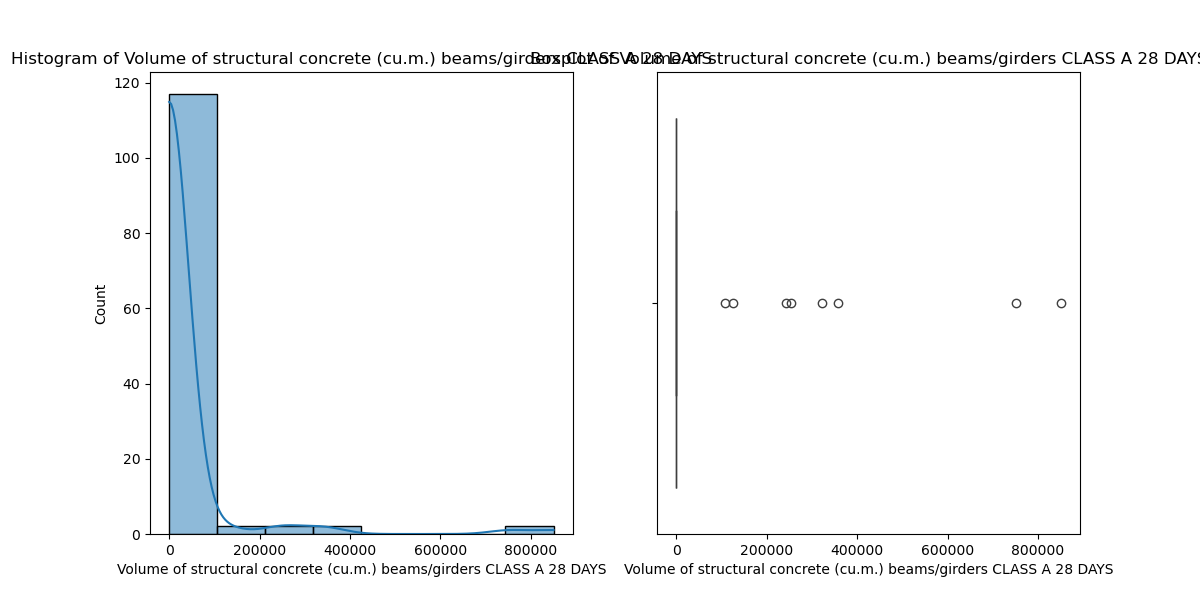

Displayed visualizations\Volume_of_structural_concrete__cu_m___beams_girders_CLASS_A_28_DAYS_visualization.png


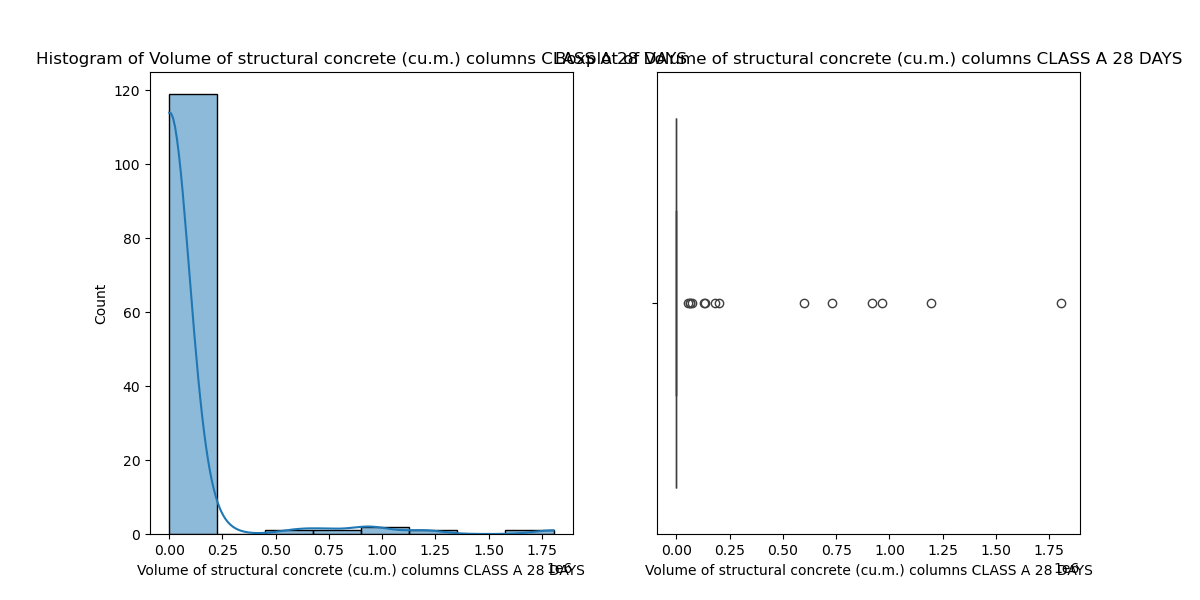

Displayed visualizations\Volume_of_structural_concrete__cu_m___columns_CLASS_A_28_DAYS_visualization.png


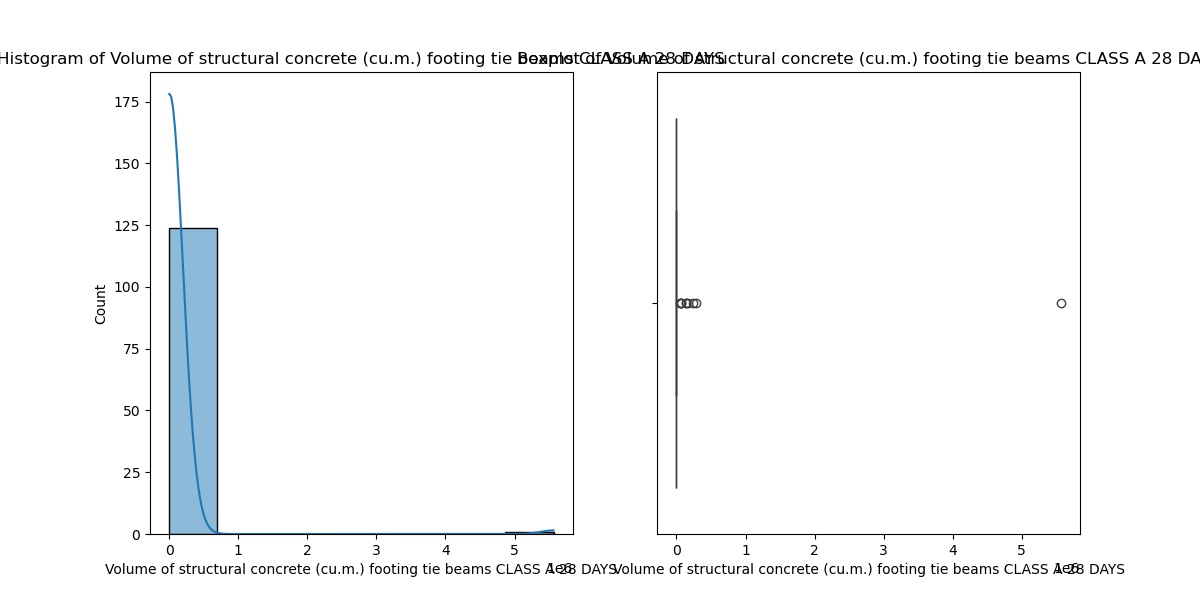

Displayed visualizations\Volume_of_structural_concrete__cu_m___footing_tie_beams_CLASS_A_28_DAYS_visualization.png


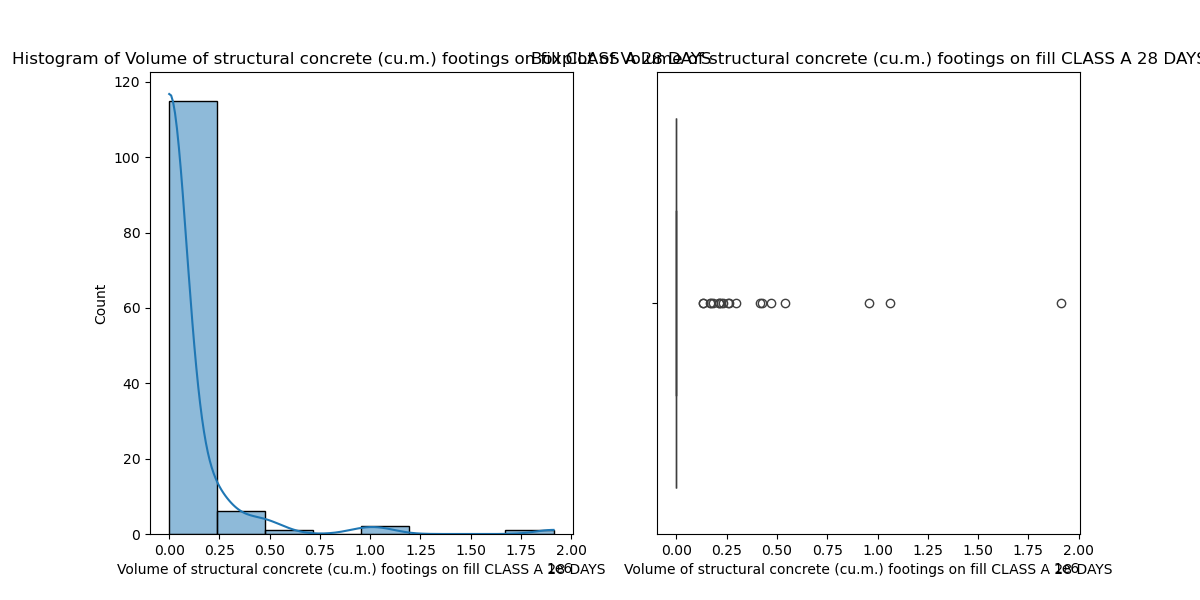

Displayed visualizations\Volume_of_structural_concrete__cu_m___footings_on_fill_CLASS_A_28_DAYS_visualization.png


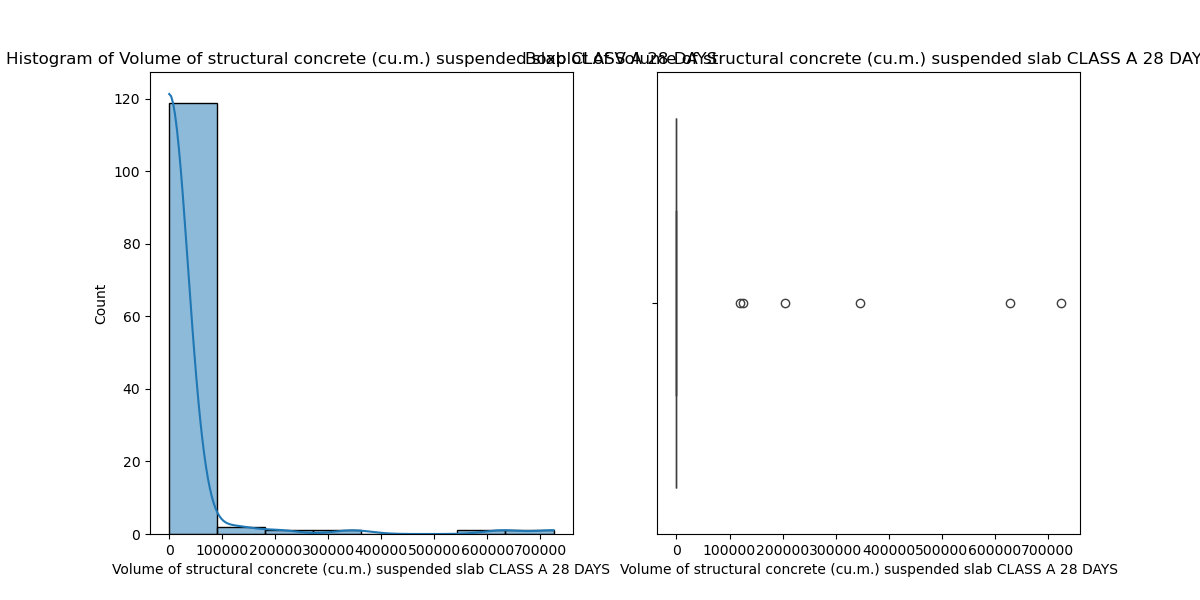

Displayed visualizations\Volume_of_structural_concrete__cu_m___suspended_slab_CLASS_A_28_DAYS_visualization.png


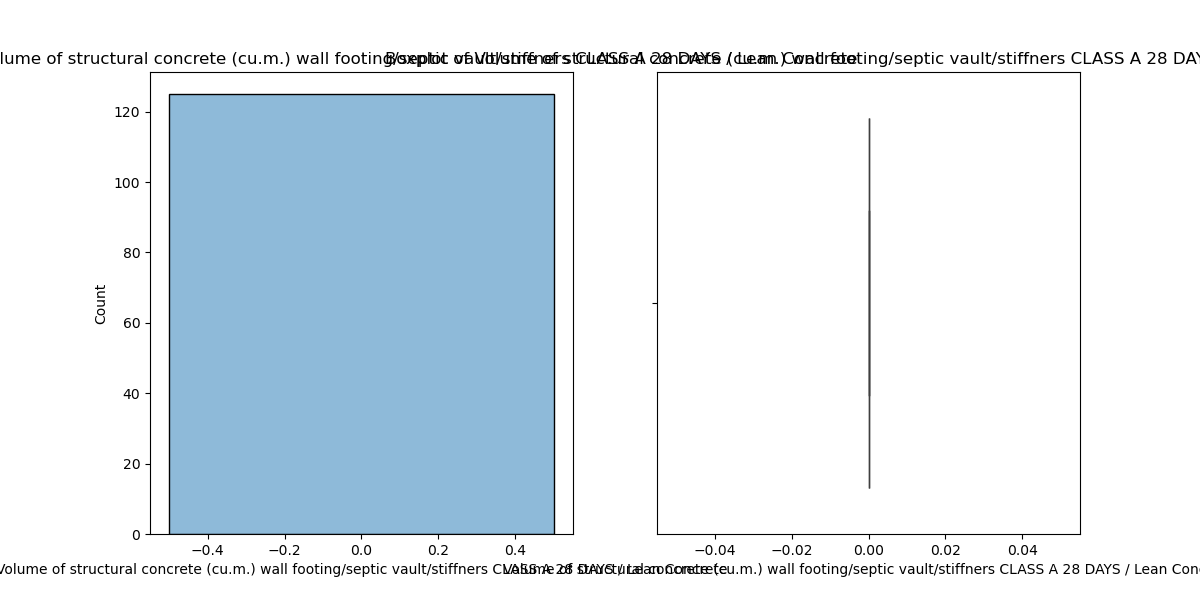

Displayed visualizations\Volume_of_structural_concrete__cu_m___wall_footing_septic_vault_stiffners_CLASS_A_28_DAYS___Lean_Concrete_visualization.png


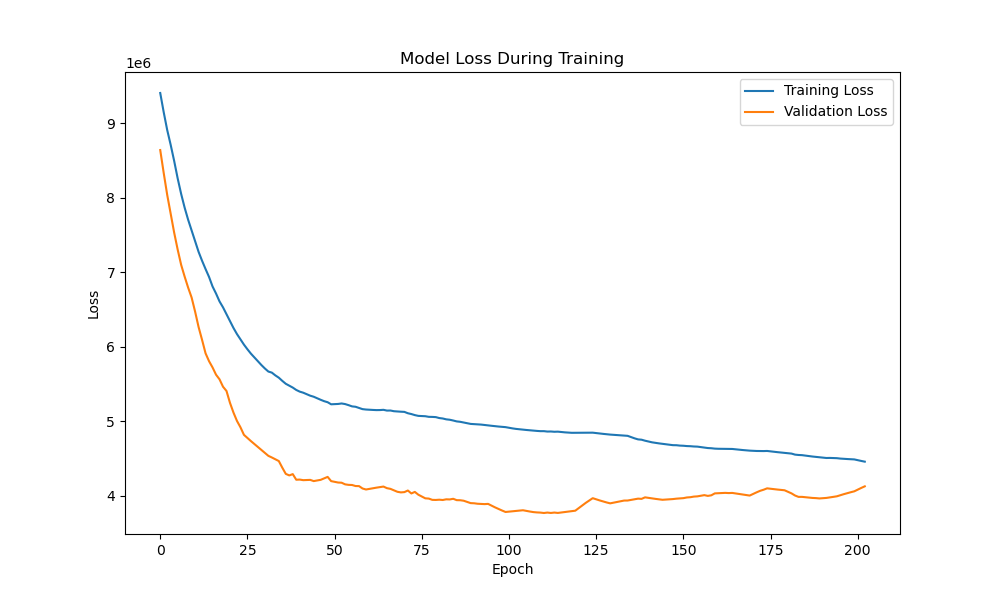

Displayed visualizations\epoch_history.png


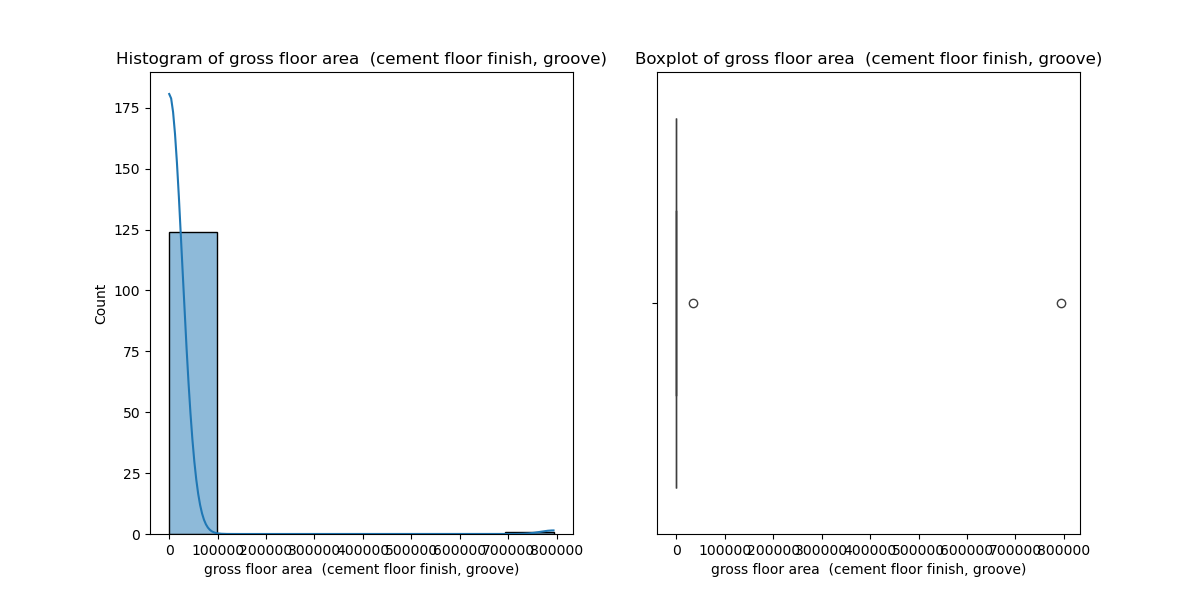

Displayed visualizations\gross_floor_area___cement_floor_finish__groove__visualization.png


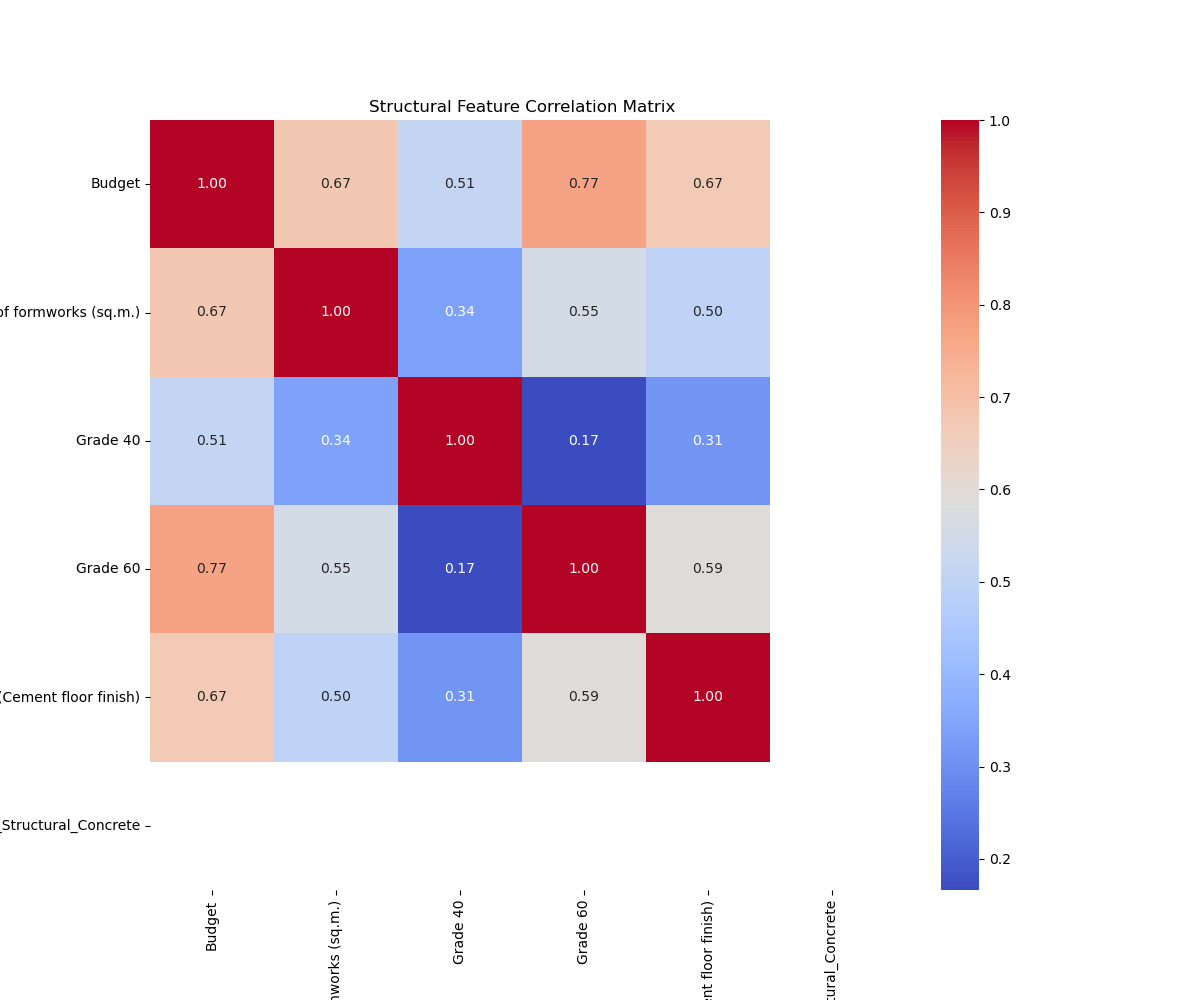

Displayed visualizations\structural_correlation_matrix.png


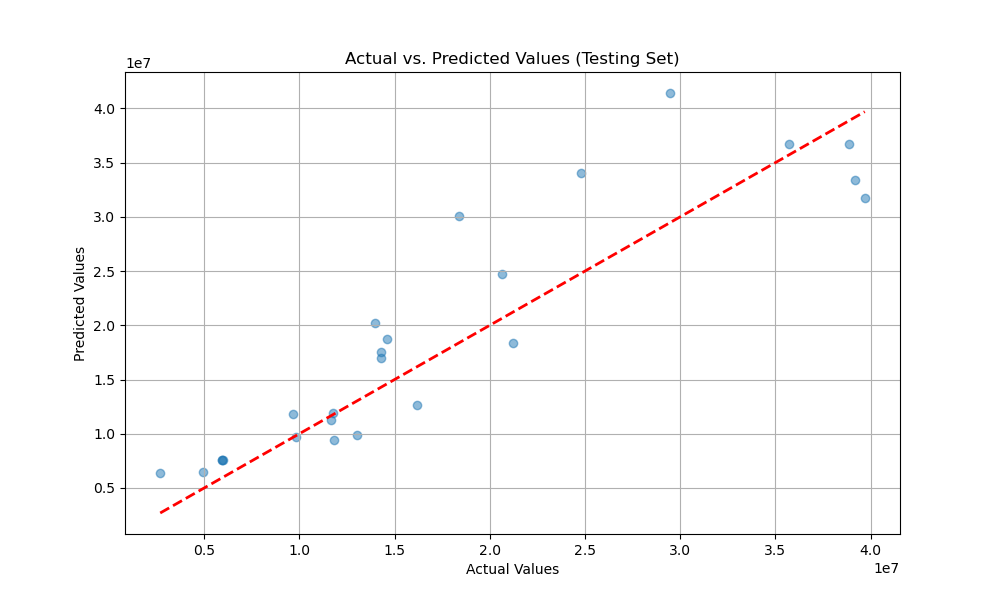

Displayed visualizations\structural_testing_actual_vs_predicted.png


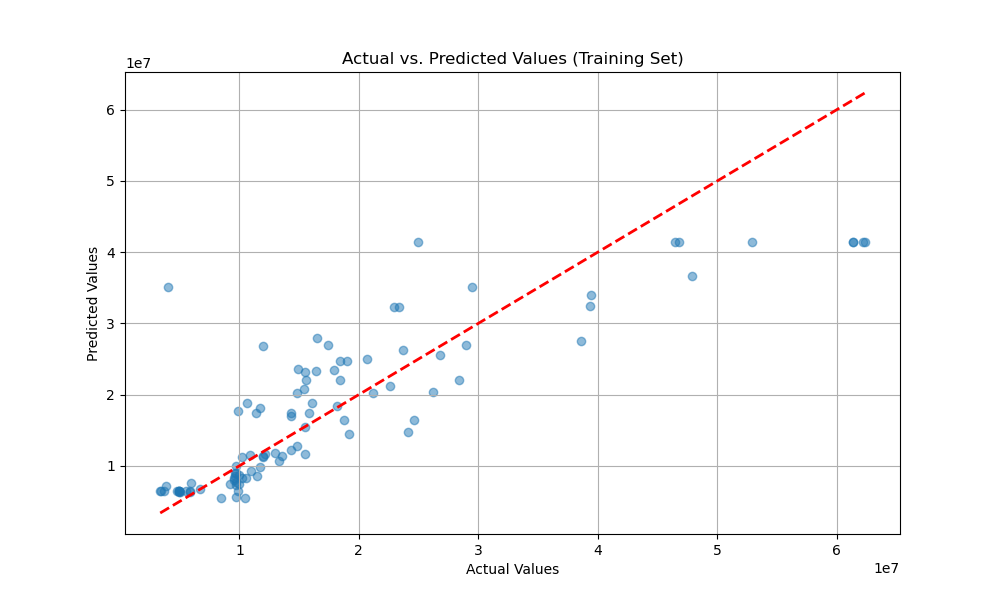

Displayed visualizations\structural_training_actual_vs_predicted.png


In [11]:
# Display saved visualization images so they are embedded in the notebook outputs
from IPython.display import Image, display
import glob

viz_dir = 'visualizations'
if os.path.exists(viz_dir):
    for img_path in sorted(glob.glob(os.path.join(viz_dir, '*.png'))):
        display(Image(filename=img_path))
        print(f"Displayed {img_path}")
else:
    print(f"Visualization directory not found: {viz_dir}")